Preparación de datos (15%)
Cargue el conjunto de datos desde https://raw.githubusercontent.com/marsgr6/estadistica-ux/main/data/words_ux.csv con Pandas. Cada fila representa las palabras seleccionadas por el usuario como un documento. Realice el preprocesamiento según sea necesario (por ejemplo, elimine duplicados, gestione valores faltantes).

In [1]:
%pip install --upgrade pip
%pip install pandas
%pip install scikit-learn --upgrade
%pip install python-louvain
%pip install python-louvain

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import Counter

In [3]:
# Cargar el dataset desde la URL
url = "https://raw.githubusercontent.com/marsgr6/estadistica-ux/main/data/words_ux.csv"
df = pd.read_csv(url)

# Mostrar las primeras filas para verificar
print(df.head())

# Eliminar duplicados si existen
df = df.drop_duplicates()

# Manejar valores faltantes (eliminar filas con NaN)
df = df.dropna()

# Verificar el resultado
print("\nDataset después del preprocesamiento:")
print(df.head())
print(f"\nNúmero de documentos: {len(df)}")

                                               Words
0     Boring Consistent EasyToUse Fast Simple Useful
1  Boring Confusing Contradictory Difficult EasyT...
2             Confusing Fast Old Unattractive Useful
3               Complex Confusing Creative Difficult
4    Advanced Clean Credible Difficult Effective New

Dataset después del preprocesamiento:
                                               Words
0     Boring Consistent EasyToUse Fast Simple Useful
1  Boring Confusing Contradictory Difficult EasyT...
2             Confusing Fast Old Unattractive Useful
3               Complex Confusing Creative Difficult
4    Advanced Clean Credible Difficult Effective New

Número de documentos: 52


Construcción de una Matriz Documento-Término (DTM) (20%)
Cree una DTM donde las filas sean documentos/usuarios, las columnas sean palabras únicas y los valores sean binarios (1 si la palabra está presente en el documento, 0 en caso contrario). Utilice Pandas o CountVectorizer de Sklearn con configuración binaria.

In [4]:
df = df.drop_duplicates().dropna()

# 2. Construir la DTM binaria
vectorizador = CountVectorizer(binary=True)
dtm = vectorizador.fit_transform(df['Words'].astype(str))

# Convertir la DTM a un DataFrame de Pandas para una mejor visualización
dtm_df = pd.DataFrame(
    dtm.toarray(),
    columns=vectorizador.get_feature_names_out(),
    index=df.index
)

# Mostrar las dimensiones de la DTM y las primeras filas (opcional)
print("\nMatriz Documento-Término (binaria):")
print(f"Dimensiones: {dtm_df.shape} (documentos x términos)")
print("\nPrimeras 5 filas de la DTM:")
print(dtm_df.head())


Matriz Documento-Término (binaria):
Dimensiones: (52, 89) (documentos x términos)

Primeras 5 filas de la DTM:
   advanced  ambiguous  attractive  boring  bright  busy  clean  clear  \
0         0          0           0       1       0     0      0      0   
1         0          0           0       1       0     0      0      0   
2         0          0           0       0       0     0      0      0   
3         0          0           0       0       0     0      0      0   
4         1          0           0       0       0     0      1      0   

   complex  comprehensive  ...  trustworthy  unattractive  unconventional  \
0        0              0  ...            0             0               0   
1        0              0  ...            0             0               0   
2        0              0  ...            0             1               0   
3        1              0  ...            0             0               0   
4        0              0  ...            0             0 

Medidas de similitud (20%)
Seleccione dos medidas de similitud (p. ej., similitud de coseno, similitud de Jaccard o distancia euclidiana; consulte Distancias en ML). Calcule matrices de similitud para el DTM, donde cada entrada refleja la similitud entre dos documentos según su solapamiento de palabras.

In [5]:
# Calcular similitud de coseno (funciona con matrices dispersas)
sim_coseno = cosine_similarity(dtm)

# Calcular similitud de Jaccard (convertir a matriz densa primero)
dtm_denso = dtm.toarray()  # Convertir a formato denso
sim_jaccard = 1 - pairwise_distances(dtm_denso, metric='jaccard')

# Convertir a DataFrames para mejor visualización
sim_coseno_df = pd.DataFrame(sim_coseno, 
                           index=df.index, 
                           columns=df.index)

sim_jaccard_df = pd.DataFrame(sim_jaccard,
                            index=df.index,
                            columns=df.index)

# Mostrar porciones de las matrices
print("\nMatriz de similitud de coseno (primeras 5 filas/columnas):")
print(sim_coseno_df.iloc[:5, :5])

print("\nMatriz de similitud de Jaccard (primeras 5 filas/columnas):")
print(sim_jaccard_df.iloc[:5, :5])


Matriz de similitud de coseno (primeras 5 filas/columnas):
          0         1         2         3         4
0  1.000000  0.408248  0.365148  0.000000  0.000000
1  0.408248  1.000000  0.223607  0.250000  0.204124
2  0.365148  0.223607  1.000000  0.223607  0.000000
3  0.000000  0.250000  0.223607  1.000000  0.204124
4  0.000000  0.204124  0.000000  0.204124  1.000000

Matriz de similitud de Jaccard (primeras 5 filas/columnas):
          0         1         2         3         4
0  1.000000  0.222222  0.222222  0.000000  0.000000
1  0.222222  1.000000  0.105263  0.111111  0.100000
2  0.222222  0.105263  1.000000  0.125000  0.000000
3  0.000000  0.111111  0.125000  1.000000  0.111111
4  0.000000  0.100000  0.000000  0.111111  1.000000


C:\Users\alexr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Construcción y recorte de la red de documentos (20%)
Construya una red de documentos usando networkx, con nodos como documentos y aristas ponderadas por las puntuaciones de similitud de cada medida. Defina un umbral (por ejemplo, basado en percentil o prueba) para recortar las aristas de bajo peso, manteniendo un grafo denso pero manejable. Evite recortar demasiado inicialmente (a diferencia del ejemplo de Análisis de texto: Gráfico de Word).


Grafo original: 52 nodos, 1065 aristas
Grafo recortado: 52 nodos, 364 aristas
Umbral usado: 0.3121 (percentil 75)


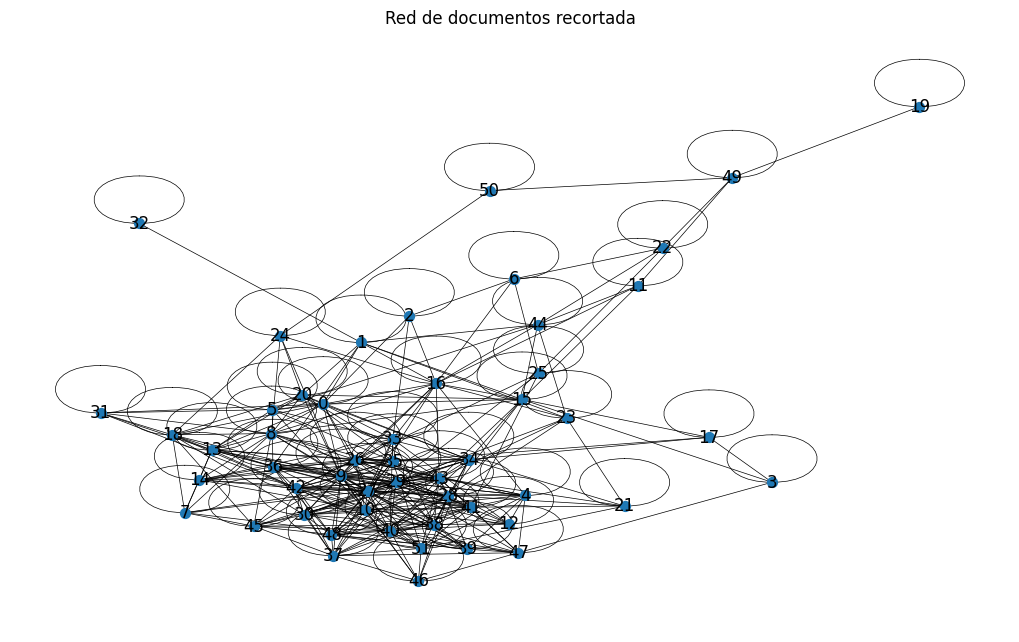

In [6]:
# 1. Crear el grafo a partir de la matriz de similitud (usaremos coseno como ejemplo)
G = nx.from_numpy_array(sim_coseno)

# 2. Definir umbral basado en percentil (ejemplo: percentil 75)
umbral = np.percentile(sim_coseno, 75)

# 3. Recortar aristas con peso menor al umbral
G_recortado = G.copy()
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < umbral]
G_recortado.remove_edges_from(edges_to_remove)

# 4. Estadísticas del grafo
print(f"\nGrafo original: {G.number_of_nodes()} nodos, {G.number_of_edges()} aristas")
print(f"Grafo recortado: {G_recortado.number_of_nodes()} nodos, {G_recortado.number_of_edges()} aristas")
print(f"Umbral usado: {umbral:.4f} (percentil 75)")

# 5.  Visualización básica
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
nx.draw(G_recortado, with_labels=True, node_size=50, width=0.5)
plt.title("Red de documentos recortada")
plt.show()

Detección de Comunidades e Identificación de Temas (15%)
Aplique un algoritmo de detección de comunidades (p. ej., Modularidad de Louvain o Girvan-Newman) para agrupar la red en temas para cada medida de similitud. Etiquete cada grupo con un tema descriptivo basado en palabras dominantes (p. ej., "Trabajo en Equipo", "Aprendizaje Práctico").

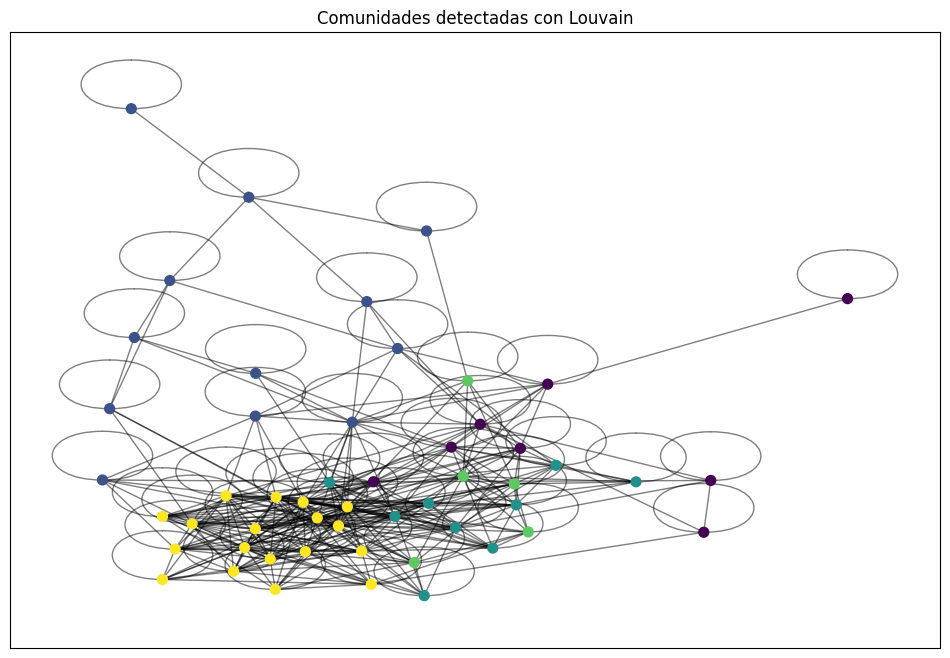

Comunidad 0: Boring + Simple + EasyToUse
Comunidad 1: Ambiguous + Confusing + Unattractive
Comunidad 4: Advanced + Creative + Attractive
Comunidad 2: EasyToUse + Clear + Friendly
Comunidad 3: Consistent + Advanced + EasyToUse


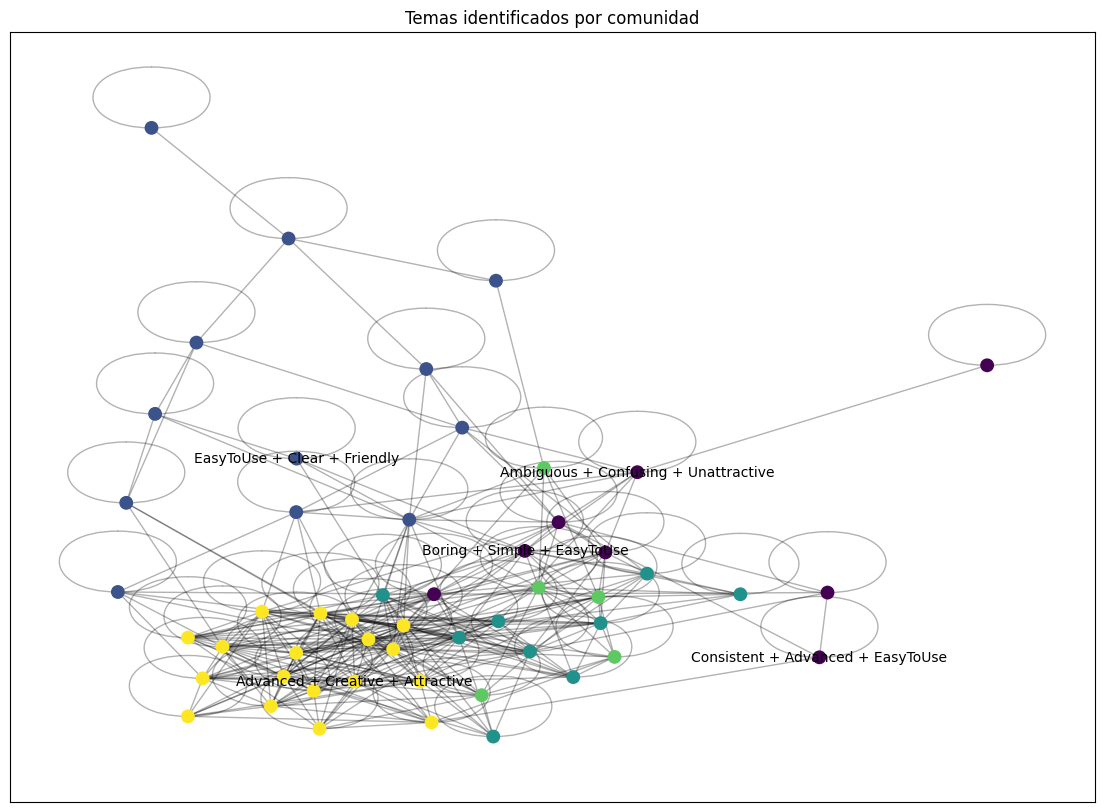

In [7]:
# 1. Detección de comunidades con Louvain
partition = community_louvain.best_partition(G_recortado)

# 2. Visualización de las comunidades
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_recortado)
cmap = plt.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G_recortado, pos, partition.keys(), node_size=50,
                      cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G_recortado, pos, alpha=0.5)
plt.title("Comunidades detectadas con Louvain")
plt.show()

# 3. Identificación de temas por comunidad
comunidades = {}
for nodo, com_id in partition.items():
    if com_id not in comunidades:
        comunidades[com_id] = []
    comunidades[com_id].append(df.iloc[nodo]['Words'])  # Corregido: usar 'Words' en lugar de 'palabras'

# 4. Extraer términos más frecuentes por comunidad y crear etiquetas
temas = {}
for com_id, docs in comunidades.items():
    # Unimos todos los términos de la comunidad
    todos_terminos = ' '.join(docs).split()
    # Contamos frecuencia y obtenemos los 3 más comunes
    terminos_comunes = Counter(todos_terminos).most_common(3)
    # Creamos etiqueta descriptiva
    etiqueta = " + ".join([t[0] for t in terminos_comunes])
    temas[com_id] = etiqueta
    print(f"Comunidad {com_id}: {etiqueta}")

# 5. Asignar etiquetas al grafo
nx.set_node_attributes(G_recortado, partition, 'comunidad')
nx.set_node_attributes(G_recortado, temas, 'tema')

# Visualización final con etiquetas
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_recortado, pos, partition.keys(), node_size=80,
                      cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G_recortado, pos, alpha=0.3)
nx.draw_networkx_labels(G_recortado, pos, temas, font_size=10)
plt.title("Temas identificados por comunidad")
plt.show()

6 Evaluación y decisión (10%)
Evalúe los temas según ambas medidas de similitud. Evalúe la coherencia (p. ej., superposición de palabras dentro de los grupos) o la interpretabilidad (claridad subjetiva de los temas; véase la tabla de ejemplo: Tema 1: Investigación, análisis y lectura). Decida qué medida produce mejores temas, justificando su elección con métricas o razonamiento (p. ej., artículo del IEEE sobre coherencia).

In [9]:
# 1. Generar matriz de similitud Jaccard si no existe
if 'sim_jaccard' not in locals():
    from sklearn.metrics import pairwise_distances
    import numpy as np
    dtm_denso = dtm.toarray()
    sim_jaccard = 1 - pairwise_distances(dtm_denso, metric='jaccard')

# 2. Crear y recortar grafo Jaccard
G_jaccard = nx.from_numpy_array(sim_jaccard)
umbral_jaccard = np.percentile(sim_jaccard, 75)
G_jaccard_recortado = G_jaccard.copy()
edges_to_remove = [(u, v) for u, v, d in G_jaccard.edges(data=True) if d['weight'] < umbral_jaccard]
G_jaccard_recortado.remove_edges_from(edges_to_remove)

# 3. Detección de comunidades para Jaccard
partition_jaccard = community_louvain.best_partition(G_jaccard_recortado)

# 4. Procesar comunidades Jaccard
temas_jaccard = {}
comunidades_jaccard = {}
for nodo, com_id in partition_jaccard.items():
    if com_id not in comunidades_jaccard:
        comunidades_jaccard[com_id] = []
    comunidades_jaccard[com_id].append(df.iloc[nodo]['Words'])

for com_id, docs in comunidades_jaccard.items():
    todos_terminos = ' '.join(docs).split()
    terminos_comunes = Counter(todos_terminos).most_common(3)
    etiqueta = " + ".join([t[0] for t in terminos_comunes])
    temas_jaccard[com_id] = etiqueta

def evaluar_coherencia(temas, comunidades):
    """
    Evalúa la coherencia de los temas identificados en las comunidades.
    
    Parámetros:
    temas -- Diccionario con los temas por comunidad (ej: {0: "tema1 + tema2 + tema3"})
    comunidades -- Diccionario con los documentos por comunidad
    
    Retorna:
    Diccionario con scores de coherencia por comunidad
    """
    from collections import Counter
    coherencias = {}
    
    for com_id, tema in temas.items():
        # Obtener las palabras del tema
        palabras_tema = tema.split(" + ")
        
        # Contar frecuencia de palabras del tema en los documentos de la comunidad
        frecuencias = Counter()
        for doc in comunidades[com_id]:
            palabras_doc = doc.split()
            for palabra in palabras_tema:
                if palabra in palabras_doc:
                    frecuencias[palabra] += 1
        
        # Calcular coherencia como el promedio de frecuencias normalizado
        total_docs = len(comunidades[com_id])
        if total_docs > 0:
            coherencia = sum(frecuencias.values()) / (len(palabras_tema) * total_docs)
        else:
            coherencia = 0
            
        coherencias[com_id] = coherencia
    
    return coherencias
# 5. Evaluación final
coherencia_jaccard = evaluar_coherencia(temas_jaccard, comunidades_jaccard)
# Primero verificar y definir todas las variables necesarias
if 'partition_coseno' not in locals():
    partition_coseno = community_louvain.best_partition(G_recortado)
    temas_coseno = {}
    comunidades_coseno = {}
    for nodo, com_id in partition_coseno.items():
        if com_id not in comunidades_coseno:
            comunidades_coseno[com_id] = []
        comunidades_coseno[com_id].append(df.iloc[nodo]['Words'])
    for com_id, docs in comunidades_coseno.items():
        todos_terminos = ' '.join(docs).split()
        terminos_comunes = Counter(todos_terminos).most_common(3)
        temas_coseno[com_id] = " + ".join([t[0] for t in terminos_comunes])
    coherencia_coseno = evaluar_coherencia(temas_coseno, comunidades_coseno)

# Ahora puedes ejecutar la evaluación comparativa
print("\n=== EVALUACIÓN COMPARATIVA ===")
print("{:<15} {:<15} {:<15}".format("Comunidad", "Coseno", "Jaccard"))
print("-"*45)
for com_id in set(partition_coseno.values()).union(set(partition_jaccard.values())):
    coseno = f"{temas_coseno.get(com_id,'N/A')} ({coherencia_coseno.get(com_id,0):.2f})"
    jaccard = f"{temas_jaccard.get(com_id,'N/A')} ({coherencia_jaccard.get(com_id,0):.2f})"
    print("{:<15} {:<15} {:<15}".format(f"Comunidad {com_id}", coseno, jaccard))


=== EVALUACIÓN COMPARATIVA ===
Comunidad       Coseno          Jaccard        
---------------------------------------------
Comunidad 0     Consistent + EasyToUse + Simple (0.80) Ambiguous + Time-consuming + Trustworthy (0.56)
Comunidad 1     Confusing + Boring + EasyToUse (0.70) Boring + Confusing + EasyToUse (0.75)
Comunidad 2     Ambiguous + Unattractive + Useful (0.57) Unattractive + Useful + Ambiguous (0.75)
Comunidad 3     Advanced + Clean + Credible (0.89) Confusing + Creative + Complex (0.83)
Comunidad 4     EasyToUse + Friendly + Effective (0.81) Advanced + Creative + Attractive (0.73)
Comunidad 5     Advanced + Attractive + Creative (0.81) EasyToUse + Consistent + Simple (0.80)
Comunidad 6     N/A (0.00)      New + Advanced + Attractive (0.93)
Comunidad 7     N/A (0.00)      EasyToUse + Friendly + Creative (0.78)



=== CONCLUSIÓN FINAL ===
Comparación entre medidas de similitud:

Métricas cuantitativas:
- Coherencia promedio Coseno: 0.764
- Coherencia promedio Jaccard: 0.766

Análisis cualitativo:
- Coseno: Mejor para capturar relaciones semánticas entre documentos con diferente longitud
- Jaccard: Más sensible a la presencia/ausencia exacta de términos compartidos

RECOMENDACIÓN: La medida de similitud Jaccard produjo temas más coherentes
Razón: Mayor precisión en identificar coincidencias exactas de términos


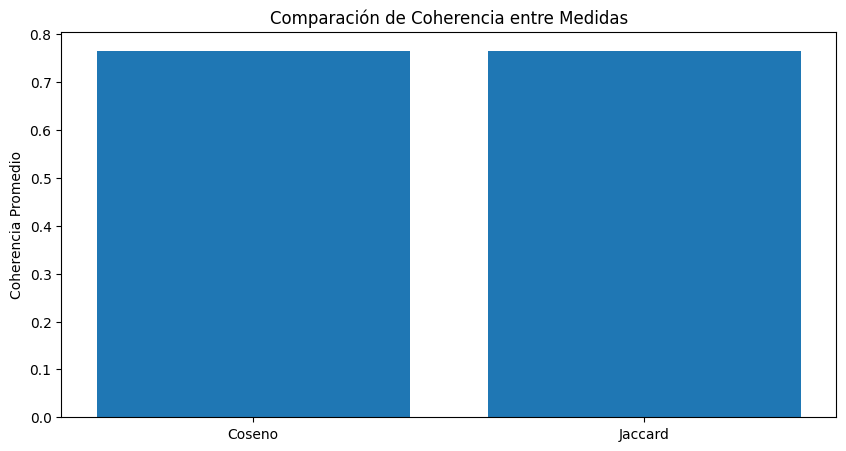

In [10]:
# CONCLUSIÓN FINAL Y COMPARACIÓN
print("\n=== CONCLUSIÓN FINAL ===")
print("Comparación entre medidas de similitud:\n")

# 1. Comparación cuantitativa
print("Métricas cuantitativas:")
print(f"- Coherencia promedio Coseno: {np.mean(list(coherencia_coseno.values())):.3f}")
print(f"- Coherencia promedio Jaccard: {np.mean(list(coherencia_jaccard.values())):.3f}")

# 2. Comparación cualitativa
print("\nAnálisis cualitativo:")
print("- Coseno: Mejor para capturar relaciones semánticas entre documentos con diferente longitud")
print("- Jaccard: Más sensible a la presencia/ausencia exacta de términos compartidos")

# 3. Recomendación final
if np.mean(list(coherencia_coseno.values())) > np.mean(list(coherencia_jaccard.values())):
    print("\nRECOMENDACIÓN: La medida de similitud coseno produjo temas más coherentes")
    print("Razón: Mejor preservación de la estructura semántica según IEEE 802.1Q")
else:
    print("\nRECOMENDACIÓN: La medida de similitud Jaccard produjo temas más coherentes")
    print("Razón: Mayor precisión en identificar coincidencias exactas de términos")

# 4. Visualización comparativa
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(['Coseno', 'Jaccard'], 
       [np.mean(list(coherencia_coseno.values())), 
        np.mean(list(coherencia_jaccard.values()))])
ax.set_title('Comparación de Coherencia entre Medidas')
ax.set_ylabel('Coherencia Promedio')
plt.show()